# Simple GRPO Carla Environment Tutorial

This notebook demonstrates how to use the GRPO Carla environment for reinforcement learning.

## What is GRPO Carla Environment?

The GRPO Carla environment is a specialized wrapper that provides:
- **Dynamic branching**: Switch between single and parallel execution modes
- **Snapshot system**: Save and restore environment states for multi-turn rollouts
- **Parallel exploration**: Run multiple CARLA instances simultaneously
- **GRPO optimization**: Collect multiple trajectories from the same state

### Key Features:
- Two execution modes: Single and Branching
- Snapshot/restore for state preservation
- Lazy initialization (creates instances on demand)
- Thread pool for parallel operations

## Server Setup

Before running this notebook, make sure the CARLA server is running:

```bash
# Start the CARLA microservice
python microservice_manager.py --num-services 1
```

The server should be available at: `http://localhost:8080`

If you encounter any issues, you can manually kill processes and restart the server.

In [1]:
import subprocess, re

def kill_carla_processes_on_gpu(gpu_index: int = 0):
    """Kill CARLA processes on specific GPU"""
    try:
        raw = subprocess.check_output("nvidia-smi", shell=True).decode()
        pattern = rf'\|\s+{gpu_index}\s+\S+\s+\S+\s+(\d+)\s+C\+G\s+.*CarlaUE4'
        pids = re.findall(pattern, raw)
        if not pids:
            print(f"No CarlaUE4 processes found on GPU {gpu_index}")
            return
        for pid in pids:
            print(f"Killing CarlaUE4 process with PID {pid} on GPU {gpu_index}")
            subprocess.run(["kill", "-9", pid], check=True)
    except Exception as e:
        print(f"Error killing CARLA processes: {e}")

def kill_python_processes_on_gpu(gpu_index: int = 0):
    """Kill Python processes on specific GPU"""
    try:
        raw = subprocess.check_output("nvidia-smi", shell=True).decode()
        pattern = rf'\|\s+{gpu_index}\s+\S+\s+\S+\s+(\d+)\s+C\s+.*bin/python'
        pids = re.findall(pattern, raw)
        if not pids:
            print(f"No python processes found on GPU {gpu_index}")
            return
        for pid in pids:
            print(f"Killing python process with PID {pid} on GPU {gpu_index}")
            subprocess.run(["kill", "-9", pid], check=True)
    except Exception as e:
        print(f"Error killing Python processes: {e}")

def cleanup_gpu_processes():
    """Clean up GPU processes"""
    for gpu_id in [0, 1]:
        kill_carla_processes_on_gpu(gpu_id)
        kill_python_processes_on_gpu(gpu_id)

cleanup_gpu_processes()

No CarlaUE4 processes found on GPU 0
No python processes found on GPU 0
Killing CarlaUE4 process with PID 221388 on GPU 1
No python processes found on GPU 1


In [2]:
# Clean API ports (8080-8083)
for port in range(8080, 8084):
    try:
        result = subprocess.run(["lsof", "-ti", f":{port}"], capture_output=True, text=True)
        if result.returncode == 0:
            pids = result.stdout.strip().split('\n')
            for pid in pids:
                if pid:
                    subprocess.run(["kill", "-9", pid], capture_output=True)
    except Exception as e:
        pass

# Clean CARLA ports (2000-2012)
for port in range(2000, 2013):
    try:
        result = subprocess.run(["lsof", "-ti", f":{port}"], capture_output=True, text=True)
        if result.returncode == 0:
            pids = result.stdout.strip().split('\n')
            for pid in pids:
                if pid:
                    subprocess.run(["kill", "-9", pid], capture_output=True)
    except Exception as e:
        pass

# Clean traffic manager ports (3000-3012)
for port in range(3000, 3013):
    try:
        result = subprocess.run(["lsof", "-ti", f":{port}"], capture_output=True, text=True)
        if result.returncode == 0:
            pids = result.stdout.strip().split('\n')
            for pid in pids:
                if pid:
                    subprocess.run(["kill", "-9", pid], capture_output=True)
    except Exception as e:
        pass


In [3]:
# Import required libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import logging

# Add client path to Python path
client_path = str(Path.cwd().parent / "client")
if client_path not in sys.path:
    sys.path.insert(0, client_path)

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Import GRPO Carla environment
try:
    from grpo_carla_env import GRPOCarlaEnv
    print("✅ Successfully imported GRPOCarlaEnv")
except ImportError as e:
    print(f"❌ Import error: {e}")
    raise

✅ Successfully imported GRPOCarlaEnv


## 1. Environment Setup

In [4]:
# Configuration
SERVER_URL = "http://localhost:8080"
TIMEOUT = 60.0

# Create GRPO environment with branching capacity of 4
env = GRPOCarlaEnv(
    num_services=4,  # Maximum number of parallel branches
    service_urls=[SERVER_URL],  # Start with one service
    render_mode="rgb_array",
    max_steps=100,
    timeout=TIMEOUT
)

print("✅ GRPO Environment created!")
print(f"📊 Configuration:")
print(f"   Max branches: {env.max_branches}")
print(f"   Current mode: {env.current_mode}")
print(f"   Is branching: {env.is_branching}")
print(f"   Timeout: {env.timeout}s")

/home/oh/anaconda3/envs/my_ad_env/lib/python3.8/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/oh/anaconda3/envs/my_ad_env/lib/python3.8/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
INFO:carla_env:Connected to CARLA server at http://localhost:8080
INFO:grpo_carla_env:Created environment 0 at http://localhost:8080


✅ GRPO Environment created!
📊 Configuration:
   Max branches: 1
   Current mode: single
   Is branching: False
   Timeout: 60.0s


## 2. Understanding Action and Observation Spaces

In [5]:
# Action space format: [throttle, brake, steer]
print("🎮 Action Space:")
print(f"   Type: {type(env.action_space)}")
print(f"   Shape: {env.action_space.shape}")
print(f"   Range: [{env.action_space.low}, {env.action_space.high}]")
print(f"   Format: [throttle, brake, steer]")

# Helper function to create actions
def create_action(throttle=0.0, brake=0.0, steer=0.0):
    """Create a valid action vector."""
    action = np.array([throttle, brake, steer], dtype=np.float32)
    return np.clip(action, env.action_space.low, env.action_space.high)

# Define common actions
actions = {
    'stop': create_action(0.0, 1.0, 0.0),
    'forward': create_action(0.5, 0.0, 0.0),
    'turn_left': create_action(0.3, 0.0, -0.5),
    'turn_right': create_action(0.3, 0.0, 0.5),
}

print("\n📋 Common Actions:")
for name, action in actions.items():
    print(f"   {name:12s}: throttle={action[0]:.1f}, brake={action[1]:.1f}, steer={action[2]:.1f}")

🎮 Action Space:
   Type: <class 'gymnasium.spaces.box.Box'>
   Shape: (3,)
   Range: [[ 0.  0. -1.], [1. 1. 1.]]
   Format: [throttle, brake, steer]

📋 Common Actions:
   stop        : throttle=0.0, brake=1.0, steer=0.0
   forward     : throttle=0.5, brake=0.0, steer=0.0
   turn_left   : throttle=0.3, brake=0.0, steer=-0.5
   turn_right  : throttle=0.3, brake=0.0, steer=0.5


In [6]:
# Observation space structure
print("👁️ Observation Space:")
print(f"   Type: {type(env.observation_space)}")
print(f"   Components: {list(env.observation_space.spaces.keys())}")

print("\n📊 Observation Details:")
for key, space in env.observation_space.spaces.items():
    if hasattr(space, 'shape'):
        print(f"   {key:15s}: {space.dtype} {space.shape}")
    else:
        print(f"   {key:15s}: {type(space)}")

👁️ Observation Space:
   Type: <class 'gymnasium.spaces.dict.Dict'>
   Components: ['center_image', 'left_image', 'navigation', 'right_image', 'scenario_info', 'vehicle_state']

📊 Observation Details:
   center_image   : uint8 (512, 1024, 3)
   left_image     : uint8 (512, 1024, 3)
   navigation     : None None
   right_image    : uint8 (512, 1024, 3)
   scenario_info  : None None
   vehicle_state  : None None


In [7]:
# Accessing Camera Images in GRPO Carla Environment
print("📸 Camera Image Access Demo")
print("=" * 40)

# In GRPO Carla Environment, images are primarily accessed through the observation dictionary
# The observation contains three camera views: left, center, and right

print("\n👁️ Available Camera Images:")
print("   • obs['left_image'] - Left camera view")
print("   • obs['center_image'] - Center camera view") 
print("   • obs['right_image'] - Right camera view")

print("\n📊 Image Properties:")
print("   • Format: RGB (not BGR)")
print("   • Data type: uint8")
print("   • Value range: 0-255")
print("   • Shape: (height, width, 3)")

# Note: env.render() may return None depending on render_mode settings
# The observation images are the primary way to access camera data
print("\n💡 Best Practice:")
print("   Use observation images (obs['center_image'], etc.) for reliable camera access")
print("   These are always available and contain the actual sensor data")

📸 Camera Image Access Demo

👁️ Available Camera Images:
   • obs['left_image'] - Left camera view
   • obs['center_image'] - Center camera view
   • obs['right_image'] - Right camera view

📊 Image Properties:
   • Format: RGB (not BGR)
   • Data type: uint8
   • Value range: 0-255
   • Shape: (height, width, 3)

💡 Best Practice:
   Use observation images (obs['center_image'], etc.) for reliable camera access
   These are always available and contain the actual sensor data


## 3. Single Mode Demonstration

In single mode, we use one CARLA instance for normal exploration.

🔄 Resetting environment...
✅ Environment reset successful!
📍 Position: [ 592.3098  3910.655    371.27454]
🏃 Speed: 0.14 m/s
🧭 Command: 0


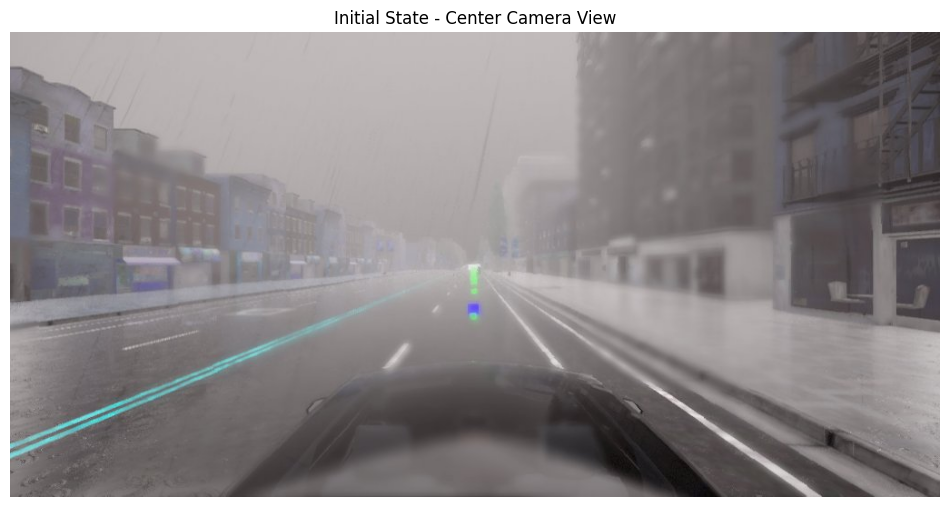

In [8]:
# Reset environment
print("🔄 Resetting environment...")
observation, info = env.reset()

print(f"✅ Environment reset successful!")
print(f"📍 Position: {observation['vehicle_state']['position']}")
print(f"🏃 Speed: {observation['vehicle_state']['speed'][0]:.2f} m/s")
print(f"🧭 Command: {observation['navigation']['command']}")

# Display initial camera view from observation
plt.figure(figsize=(12, 8))
plt.imshow(observation['center_image'])
plt.title("Initial State - Center Camera View")
plt.axis('off')
plt.show()

## 3. Single Mode Demonstration

In single mode, we use one CARLA instance for normal exploration.

📸 Displaying camera images from final observation...


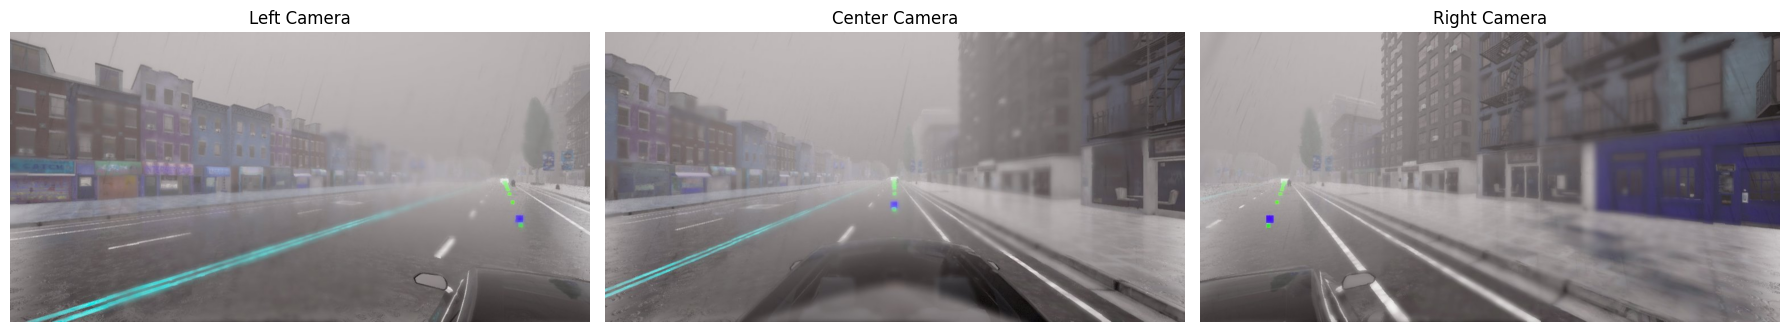


📊 Image Information:
   Center image: (512, 1024, 3) (dtype: uint8)
   Left image: (512, 1024, 3) (dtype: uint8)
   Right image: (512, 1024, 3) (dtype: uint8)
   Value range: [6, 249]

📋 Image Access Methods:
   1. obs['center_image'] - Center camera image from observation
   2. obs['left_image'] - Left camera image from observation
   3. obs['right_image'] - Right camera image from observation

💡 All images are numpy arrays with shape (height, width, 3) in RGB format
💡 These are the recommended way to access camera data in GRPO Carla Environment


In [9]:
# Display camera images from the final observation
print("📸 Displaying camera images from final observation...")

obs = observation

# Display all three camera views
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
camera_names = ['Left Camera', 'Center Camera', 'Right Camera']
camera_images = [obs['left_image'], obs['center_image'], obs['right_image']]

for ax, name, img in zip(axes, camera_names, camera_images):
    ax.imshow(img)
    ax.set_title(name)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Display image information
print("\n📊 Image Information:")
print(f"   Center image: {obs['center_image'].shape} (dtype: {obs['center_image'].dtype})")
print(f"   Left image: {obs['left_image'].shape} (dtype: {obs['left_image'].dtype})")
print(f"   Right image: {obs['right_image'].shape} (dtype: {obs['right_image'].dtype})")
print(f"   Value range: [{obs['center_image'].min()}, {obs['center_image'].max()}]")

print("\n📋 Image Access Methods:")
print("   1. obs['center_image'] - Center camera image from observation")
print("   2. obs['left_image'] - Left camera image from observation")  
print("   3. obs['right_image'] - Right camera image from observation")
print("\n💡 All images are numpy arrays with shape (height, width, 3) in RGB format")
print("💡 These are the recommended way to access camera data in GRPO Carla Environment")

🚗 Starting single mode exploration...
Step  0: pos=( 592.3, 3910.7), speed= 0.1 m/s, reward=0.000
Step  1: pos=( 592.3, 3910.7), speed= 0.1 m/s, reward=0.000
Step  2: pos=( 592.3, 3910.7), speed= 0.1 m/s, reward=0.000
Step  3: pos=( 592.3, 3910.7), speed= 0.1 m/s, reward=0.000
Step  4: pos=( 592.3, 3910.7), speed= 0.0 m/s, reward=0.000
Step  5: pos=( 592.3, 3910.7), speed= 0.0 m/s, reward=0.000
Step  6: pos=( 592.3, 3910.7), speed= 0.0 m/s, reward=0.000
Step  7: pos=( 592.3, 3910.7), speed= 0.0 m/s, reward=0.000
Step  8: pos=( 592.3, 3910.7), speed= 0.0 m/s, reward=0.000
Step  9: pos=( 592.3, 3910.7), speed= 0.0 m/s, reward=0.000
Step 10: pos=( 592.3, 3910.7), speed= 0.0 m/s, reward=0.000
Step 11: pos=( 592.3, 3910.7), speed= 0.4 m/s, reward=0.000
Step 12: pos=( 592.3, 3910.7), speed= 0.7 m/s, reward=0.000
Step 13: pos=( 592.2, 3910.7), speed= 1.1 m/s, reward=0.000
Step 14: pos=( 592.2, 3910.7), speed= 1.3 m/s, reward=0.000
Step 15: pos=( 592.1, 3910.7), speed= 1.6 m/s, reward=0.000
St

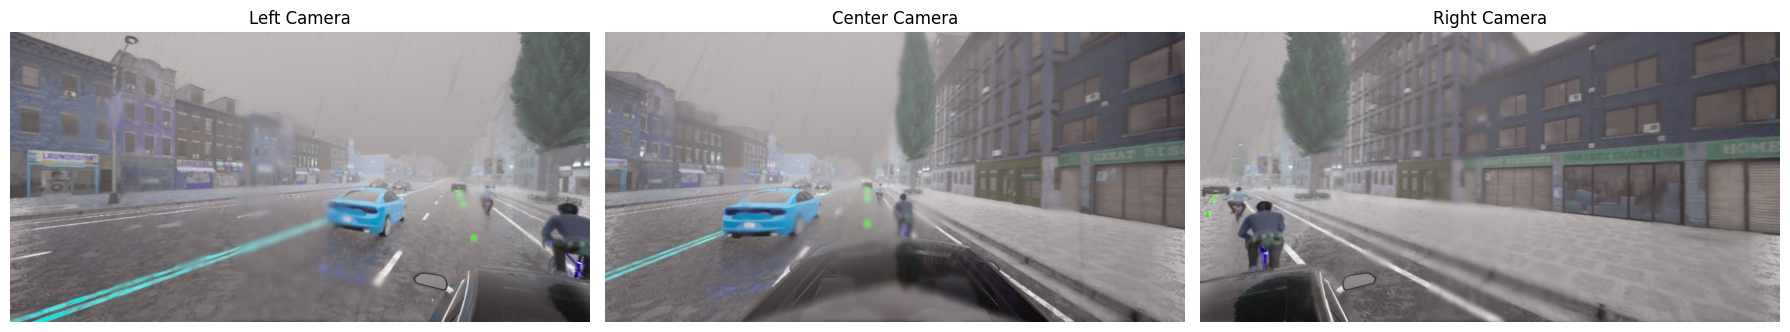

In [10]:
# Take some steps in single mode
print("🚗 Starting single mode exploration...")

trajectory = []
total_reward = 0.0

for step in range(100):
    # Create a simple forward action with slight steering variation
    action = create_action(
        throttle=1.0,
        brake=0.0,
        steer=0.2 * np.sin(step * 0.3)  # Gentle sine wave steering
    )
    
    # Execute step (use single_step for clarity)
    obs, reward, terminated, truncated, info = env.single_step(action)
    
    total_reward += reward
    
    # Record trajectory
    trajectory.append({
        'step': step,
        'position': obs['vehicle_state']['position'],
        'speed': obs['vehicle_state']['speed'][0],
        'action': action.tolist(),
        'reward': reward
    })
    # print(step)
    # print(obs['vehicle_state'])
    
    print(f"Step {step:2d}: pos=({obs['vehicle_state']['position'][0]:6.1f}, {obs['vehicle_state']['position'][1]:6.1f}), "
          f"speed={obs['vehicle_state']['speed'][0]:4.1f} m/s, reward={reward:.3f}")
    
    if terminated or truncated:
        print(f"🏁 Episode ended at step {step}")
        break

print(f"\n📊 Single mode results:")
print(f"   Total steps: {len(trajectory)}")
print(f"   Total reward: {total_reward:.3f}")
print(f"   Average speed: {np.mean([t['speed'] for t in trajectory]):.2f} m/s")

# Display all three camera views
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
camera_names = ['Left Camera', 'Center Camera', 'Right Camera']
camera_images = [obs['left_image'], obs['center_image'], obs['right_image']]

for ax, name, img in zip(axes, camera_names, camera_images):
    ax.imshow(img)
    ax.set_title(name)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Clean Up

In [11]:
# Clean up environment
print("🧹 Cleaning up environment...")
env.close()
print("✅ Environment closed successfully")

print("\n🎉 Tutorial completed!")
print("📚 You now understand the GRPO Carla Environment interface!")

🧹 Cleaning up environment...


INFO:carla_env:Environment closed successfully
INFO:grpo_carla_env:GRPO environment closed


✅ Environment closed successfully

🎉 Tutorial completed!
📚 You now understand the GRPO Carla Environment interface!
